<a href="https://colab.research.google.com/github/Recommendation-System-Project/Recommendation-system/blob/main/DR_coat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

In [2]:
def get_data():
  observed_r = np.genfromtxt("data/train.ascii", dtype=None) # observed ratings
  observed_r = observed_r.astype('float')
  observed_r[observed_r == 0] = np.nan
    
  predicted_r = np.random.randint(1,5,size=observed_r.shape) # predicted rating
    
  observed_e = predicted_r - observed_r # e_ui
  propensities = np.genfromtxt("data/our_propensities.ascii", dtype=None) # propensities for all user item pairs

  O_mask = np.int64(observed_r > 0)

  item_features = np.genfromtxt("data/item_features_encoded.ascii", dtype=None)
  user_features = np.genfromtxt("data/user_features.ascii", dtype=None)
   
  return observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features

In [3]:
observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features = get_data()

In [4]:
features_matrix = []
for u in range(O_mask.shape[0]):
  for i in range(O_mask.shape[1]):
    user_f = user_features[u]
    item_f = item_features[i]
    observed = np.concatenate((user_f, item_f))
    features_matrix.append(observed)
features_matrix = np.array(features_matrix)

In [5]:
observed_features = []
for i in O_mask.flatten():
  if i == 1:
    observed_features.append(features_matrix[i])
observed_features = np.array(observed_features)

In [6]:
observed_r_1d = observed_r.flatten()
observed_r_1d = observed_r_1d[~np.isnan(observed_r_1d)]

observed_e_1d = observed_e.flatten()
observed_e_1d = observed_e_1d[~np.isnan(observed_e_1d)]

predicted_r_1d = np.array(predicted_r*O_mask).flatten()
predicted_r_1d = predicted_r_1d[predicted_r_1d != 0]

propensities_1d = np.array(propensities*O_mask).flatten()
propensities_1d = propensities_1d[propensities_1d != 0]

In [7]:
print("observed_r: ", observed_r.shape)
print("predicted_r: ", predicted_r.shape)
print("observed_e: ", observed_e.shape)
print("propensities: ", propensities.shape)
print("O_mask: ", O_mask.shape)
print("item_features: ", item_features.shape)
print("user_features: ", user_features.shape)
print("features_matrix: ", features_matrix.shape)
print("observed_features: ", observed_features.shape)

print("observed_r_1d: ", observed_r_1d.shape)
print("observed_e_1d: ", observed_e_1d.shape)
print("predicted_r_1d: ", predicted_r_1d.shape)
print("propensities_1d: ", propensities_1d.shape)

observed_r:  (290, 300)
predicted_r:  (290, 300)
observed_e:  (290, 300)
propensities:  (290, 300)
O_mask:  (290, 300)
item_features:  (300, 21)
user_features:  (290, 14)
features_matrix:  (87000, 35)
observed_features:  (6960, 35)
observed_r_1d:  (6960,)
observed_e_1d:  (6960,)
predicted_r_1d:  (6960,)
propensities_1d:  (6960,)


In [8]:
def loss_emputation(w,y,r,e,p):
  #l(w,y) = (w*rui^2 - 2*w*y*rui + y^2 - eui)^2 / pui
  return  ((w*r)**2 - 2*w*y*r + y**2 - e)**2/p

In [9]:
#r: rui^{hat}
#e = eui
#p = pui^{hat}
def gradient_descent(w, y, le, observed_e, predicted_r, propensities, max_iter, lr=0.1):
  w.requires_grad = True
  y.requires_grad = True
  m = observed_e.shape[0]
  theta = [w.item(), y.item()]
  iter_list = []
  loss_list = []
  for i in range(max_iter):
    loss = 0
    rand1 = np.random.randint(0, m, 1)
    r = torch.from_numpy(predicted_r[rand1]).type(torch.float32)
    e = torch.from_numpy(observed_e[rand1]).type(torch.float32)
    p = torch.from_numpy(propensities[rand1]).type(torch.float32)

    output = le(w,y,r,e,p)
    output.backward()
    w.data -= lr * w.grad
    y.data -= lr * y.grad
    w.grad.fill_(0)
    y.grad.fill_(0)

    for j in range(m):
      every_loss = le(w,y,predicted_r[j],observed_e[j],propensities[j]).item()
      loss = loss + every_loss
    theta[0] = w.item()
    theta[1] = y.item()
    print("iter_count: ", i, "the loss: ",loss)
    print("theta:", theta)
    iter_list.append(i)
    loss_list.append(loss)
      
  plt.plot(iter_list, loss_list)
  plt.xlabel("iter")
  plt.ylabel("loss")
  plt.show()
  return theta, loss

In [10]:
# torch.manual_seed(10)
w = torch.randn(1)
y = torch.randn(1)
lr = 0.0001
max_iter = 1000

iter_count:  0 the loss:  263651.1513529476
theta: [-0.04493478313088417, -0.46624913811683655]
iter_count:  1 the loss:  263656.51564794034
theta: [-0.04531421884894371, -0.4658696949481964]
iter_count:  2 the loss:  263179.93192492053
theta: [-0.03589414060115814, -0.4682247042655945]
iter_count:  3 the loss:  263188.4953359924
theta: [-0.03623727709054947, -0.46788156032562256]
iter_count:  4 the loss:  263009.3561357781
theta: [-0.032447412610054016, -0.4697764813899994]
iter_count:  5 the loss:  263021.8232497126
theta: [-0.0326702781021595, -0.46970218420028687]
iter_count:  6 the loss:  263215.6657914426
theta: [-0.04058586806058884, -0.4617865979671478]
iter_count:  7 the loss:  262639.62540551275
theta: [-0.029763326048851013, -0.46539410948753357]
iter_count:  8 the loss:  262527.7115953453
theta: [-0.027988389134407043, -0.46583783626556396]
iter_count:  9 the loss:  262575.5320044905
theta: [-0.0287411417812109, -0.46564963459968567]
iter_count:  10 the loss:  262317.519541

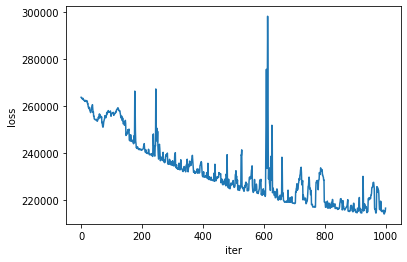

The time of execution of above program is : 700.0791399478912
theta for imputation error:  [0.28220224380493164, 0.203800767660141]


In [11]:
start = time.time()
theta,loss_list = gradient_descent(w, y, loss_emputation, observed_e_1d, predicted_r_1d, propensities_1d, max_iter, lr)
end = time.time()
    
print("The time of execution of above program is :", end-start)
print("theta for imputation error: ", theta)

In [13]:
predicted_e = theta[0]*((predicted_r - theta[1])**2)
predicted_e_1d = np.array(predicted_r*O_mask).flatten()
predicted_e_1d = predicted_r_1d[predicted_r_1d != 0]

print("predicted_e: ", predicted_e.shape)
print("predicted_e_1d: ", predicted_e_1d.shape)

predicted_e:  (290, 300)
predicted_e_1d:  (6960,)


In [14]:
import pandas as pd
import numpy as np 

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [97]:
# FM 特征组合层
class crossLayer(layers.Layer):
    def __init__(self,input_dim, output_dim=10, **kwargs):
        super(crossLayer, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        # 定义交叉特征的权重
        self.kernel = self.add_weight(name='kernel', shape=(self.input_dim, self.output_dim), initializer='glorot_uniform',trainable=True)
        
    def call(self, x): # 对照上述公式中的二次项优化公式一起理解
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return 0.5 * K.mean(a-b, 1, keepdims=True)

# 定义FM模型
def FM(feature_dim, e, p, O_mask):
    inputs = Input(shape=(feature_dim, ))
    
    # 一阶特征
    linear = Dense(units=1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(inputs)
    
    # 二阶特征
    cross = crossLayer(feature_dim)(inputs)
    add = Add()([linear, cross])  # 将一阶特征与二阶特征相加构建FM模型
    
    pred = add
    model = Model(inputs=inputs, outputs=pred)
    
    model.summary()
    # def my_loss_fn(y_true, y_pred):
    #   squared_difference = tf.square(y_true - y_pred)
    #   return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    # model.compile(loss=my_loss_fn, optimizer=optimizers.SGD())

    # 以下两段loss定义格式不应更改，keras的loss有且仅有两个参数y_true, y_pred
    def my_coef(y_true, y_pred, predicted_e, propensities, mask):
      error = tf.square(y_true - y_pred)
      error = tf.reshape(error, [290, 300])
      delta = tf.subtract(error, predicted_e)
      a = tf.multiply(mask, delta)
      b = tf.divide(a, propensities)
      return tf.add(predicted_e, b)

    def my_loss_fn(predicted_e, propensities, mask):
      def loss(y_true, y_pred):
        return my_coef(y_true, y_pred, predicted_e, propensities, mask)
      return loss
      
    model.compile(loss=my_loss_fn(predicted_e = e, propensities = p, mask = O_mask),
                  optimizer=optimizers.SGD())

    
    return model    

In [86]:
ratings = np.genfromtxt("data/train.ascii", dtype=None).astype(np.float32)
ratings

array([[0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [99]:
# x_trn, x_tst, y_trn, y_tst = train_test_split(feats, data['Label'], test_size=0.2, random_state=2020)
# x_trn = observed_features
# y_trn = observed_r_1d

x_trn = features_matrix
y_trn = ratings.flatten()

# 定义模型
# model = FM(x_trn.shape[1], predicted_e.flatten(), propensities.flatten(), O_mask.flatten())
model = FM(x_trn.shape[1], predicted_e.astype(np.float32), propensities, O_mask.astype(np.float32))

# 训练模型
model.fit(x_trn, y_trn, epochs=50, batch_size=87000, validation_data=(x_trn, y_trn))
# model.fit(x_trn, y_trn, epochs=50, batch_size=x_trn.shape[0], validation_data=(x_trn, y_trn))

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_40 (Dense)               (None, 1)            36          ['input_41[0][0]']               
                                                                                                  
 cross_layer_40 (crossLayer)    (None, 1)            350         ['input_41[0][0]']               
                                                                                                  
 add_40 (Add)                   (None, 1)            0           ['dense_40[0][0]',               
                                                                  'cross_layer_40[0][0]']  

In [92]:
model.predict(features_matrix)

array([[ 0.37100646],
       [-0.16848803],
       [ 0.09763737],
       ...,
       [ 0.03178919],
       [ 0.03672523],
       [-0.1324054 ]], dtype=float32)